In [1]:
ls

ATML-PA-2/


In [2]:
cd ATML-PA-2/Baseline

/kaggle/working/ATML-PA-2/Baseline


In [29]:
%load_ext autoreload
%autoreload 2

In [ ]:
import importlib
import utils
import architecture
import train
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
from utils.evaluation import evaluate_ds
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier

In [31]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()

classes = os.listdir(f"{root_dir}/Art")


In [33]:
import matplotlib.pyplot as plt

def analysis(source, target, config, cache_source=None, cache_target=None):

    model = resnet_classifier(num_classes=len(classes))

    if cache_source is None:
        source_ds = OfficeHomeDataset(root_dir, csv_file, source, transform)
        cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=64)

    if cache_target is None:
        target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)
        cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=64)

    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x

    import types
    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    train_workflow(truncated_model, cache_source, cache_target, config, device=device)
    evaluate_ds(cache_target, truncated_model, device, target[0], None)

    latents_s, labels_s = get_features(truncated_model[:-1], cache_source, batchsize=32, device=device)
    latents_t, labels_t = get_features(truncated_model[:-1], cache_target, batchsize=32, device=device)

    if latents_s.dim() > 2:
        latents_s = latents_s.flatten(start_dim=1)
    if latents_t.dim() > 2:
        latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(latents_s.shape[0], dtype=torch.long),   # 0 = source
        torch.ones(latents_t.shape[0], dtype=torch.long)     # 1 = target
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [34]:
model = resnet_classifier(num_classes=len(classes))

In [35]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

In [37]:
# import importlib
# import utils.dataset
# importlib.reload(utils.dataset)
# from utils.dataset import FeatureTensorDataset


cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=32)
cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=32)

Precomputing up to layer3: 100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Training:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1/2

Train loss: 1.23268 |  Train acc: 69.98 %

Test loss: 2.22268 | Test acc: 46.05 %



Training:  50%|█████     | 1/2 [00:17<00:17, 17.29s/it]


Epoch 2/2

Train loss: 0.40462 |  Train acc: 89.27 %

Test loss: 2.37856 | Test acc: 44.54 %



Training: 100%|██████████| 2/2 [00:33<00:00, 16.95s/it]



=== Evaluation for Clipart Domain ===
Accuracy: 44.54%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.7778    0.7000    0.7368        60
           1     0.6923    0.1607    0.2609        56
           2     0.6522    0.2344    0.3448        64
           3     0.7857    0.1122    0.1964        98
           4     0.9359    0.7374    0.8249        99
           5     0.4030    0.2727    0.3253        99
           6     0.5918    0.3973    0.4754        73
           7     0.5556    0.8696    0.6780        46
           8     0.5529    0.6026    0.5767        78
           9     0.6923    0.2727    0.3913        99
          10     0.7353    0.5051    0.5988        99
          11     0.1463    0.1500    0.1481        40
          12     0.3542    0.1717    0.2313        99
          13     0.4706    0.1250    0.1975        64
          14     0.6667    0.6190    0.6420        42
          15     0.1636    0.2195   

ValueError: ['1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1'] is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

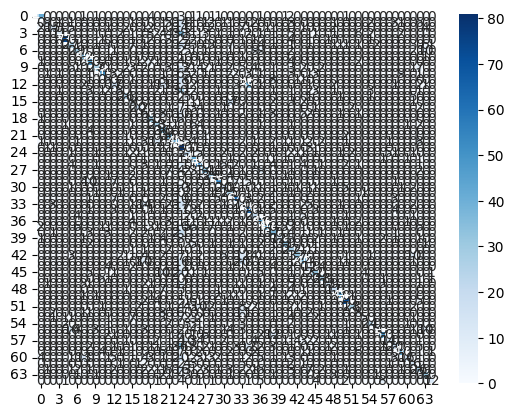

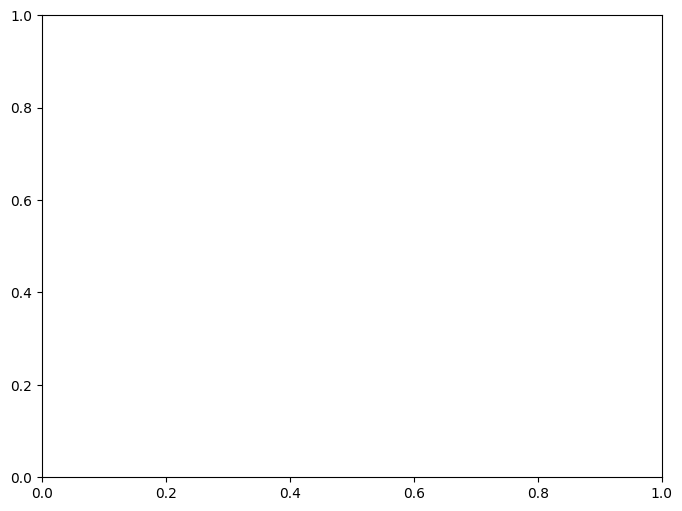

In [38]:
config = {'epochs':2, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-5}
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target, )

In [40]:
len(cache_target)

4365